# DATA 622 Big Data & Machine Learning

## Fall 2018 DATA622.001 Homework #5

### Kyle Gilde

### 11/3/18

This notebook follows Datacamp's [Apache Spark Tutorial: ML with PySpark](https://www.datacamp.com/community/tutorials/apache-spark-tutorial-machine-learning) article.

In [61]:
import findspark
findspark.init('D:\Documents\spark-2.3.2-bin-hadoop2.7')
# https://changhsinlee.com/install-pyspark-windows-jupyter/
# https://stackoverflow.com/questions/38411914/the-spark-home-env-variable-is-set-but-jupyter-notebook-doesnt-see-it-windows

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Let's create a spark session instance and test it out.

In [62]:
spark = SparkSession.builder.getOrCreate()
t = spark.sql('''select 'Hello, World!' as hello ''')
t.show()

+-------------+
|        hello|
+-------------+
|Hello, World!|
+-------------+



Let's create some simple RDDs, resilient distributed datasets, which are the building blocks of Spark. They are collections of records.

In [63]:
rdd1 = spark.sparkContext.parallelize([('a',7),('a',2),('b',2)])
rdd2 = spark.sparkContext.parallelize([("a",["x","y","z"]), ("b",["p", "r"])])
rdd3 = spark.sparkContext.parallelize(range(100))

Let's run some basic operations on them.

In [64]:
print(rdd1.reduce(lambda a, b: a + b))
rdd2.flatMapValues(lambda x: x).collect()

('a', 7, 'a', 2, 'b', 2)


[('a', 'x'), ('a', 'y'), ('a', 'z'), ('b', 'p'), ('b', 'r')]

### Creating Your First Spark Program

Let's initialize a session builder and spark context.

In [65]:
# Import SparkSession
from pyspark.sql import SparkSession

# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("Linear Regression Model") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

### The Data

The [California Housing data](http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) comes from the 1990 census. Each of the 20,460 rows represent a census block, which is the smallest geographical unit of used in the U.S Census.


The data can be downloaded by clicking [here](https://raw.githubusercontent.com/mikeizbicki/datasets/master/csv/statlib/cal_housing.data), and the headers can be found [here](https://raw.githubusercontent.com/mikeizbicki/datasets/master/csv/statlib/cal_housing.domain).

The following data dictionary was copied from the tutorial. The dependent variable for our analysis is Median house value.

- **Longitude** refers to the angular distance of a geographic place north or south of the earth’s equator for each block group;
- **Latitude** refers to the angular distance of a geographic place east or west of the earth’s equator for each block group;
- **Housing median age** is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values;
- **Total rooms** is the total number of rooms in the houses per block group;
- **Total bedrooms** is the total number of bedrooms in the houses per block group;
- **Population** is the number of inhabitants of a block group;
- **Households** refers to units of houses and their occupants per block group;
- **Median income** is used to register the median income of people that belong to a block group; And,
- **Median house value** is the dependent variable and refers to the median house value per block group.


### Loading In Your Data

Let's read in the data and headers using `pyspark`'s "lazy" operations, which means that nothing is executed until the last minute.

In [66]:
rdd = sc.textFile('D:\Documents\spark-2.3.2-bin-hadoop2.7/cal_housing.data.txt')
header = sc.textFile('D:\Documents\spark-2.3.2-bin-hadoop2.7/cal_housing.domain.txt')

Let's use the `collect` method, which considates the data on to one machine. The first 8 columns are independent variables and the last one `medianHouseValue` will be the dependent variable for our linear regression. We will use the 8 independent variables to predict the median house value for each census block.

In [67]:
header.collect()

['longitude: continuous.',
 'latitude: continuous.',
 'housingMedianAge: continuous. ',
 'totalRooms: continuous. ',
 'totalBedrooms: continuous. ',
 'population: continuous. ',
 'households: continuous. ',
 'medianIncome: continuous. ',
 'medianHouseValue: continuous. ']

Let's split the lines and then take a look at some of the data.

In [68]:
# Split lines on commas
rdd = rdd.map(lambda line: line.split(","))

In [69]:
# Inspect the first line 
print(rdd.first())

# Take top elements
rdd.top(4)

['-122.230000', '37.880000', '41.000000', '880.000000', '129.000000', '322.000000', '126.000000', '8.325200', '452600.000000']


[['-124.350000',
  '40.540000',
  '52.000000',
  '1820.000000',
  '300.000000',
  '806.000000',
  '270.000000',
  '3.014700',
  '94600.000000'],
 ['-124.300000',
  '41.840000',
  '17.000000',
  '2677.000000',
  '531.000000',
  '1244.000000',
  '456.000000',
  '3.031300',
  '103600.000000'],
 ['-124.300000',
  '41.800000',
  '19.000000',
  '2672.000000',
  '552.000000',
  '1298.000000',
  '478.000000',
  '1.979700',
  '85800.000000'],
 ['-124.270000',
  '40.690000',
  '36.000000',
  '2349.000000',
  '528.000000',
  '1194.000000',
  '465.000000',
  '2.517900',
  '79000.000000']]

The `Row` converts `PipelindRDD` object to pyspark's version of a `DataFrame`.

In [70]:
# Import the necessary modules 
from pyspark.sql import Row
print(type(rdd))
# Map the RDD to a DF
df = rdd.map(lambda line: Row(longitude=line[0], 
                              latitude=line[1], 
                              housingMedianAge=line[2],
                              totalRooms=line[3],
                              totalBedRooms=line[4],
                              population=line[5], 
                              households=line[6],
                              medianIncome=line[7],
                              medianHouseValue=line[8])).toDF()
type(df)

<class 'pyspark.rdd.PipelinedRDD'>


pyspark.sql.dataframe.DataFrame

Let's take a look at the DataFrame.

In [71]:
# Show the top 20 rows 
df.show()

+-----------+----------------+---------+-----------+----------------+------------+-----------+-------------+-----------+
| households|housingMedianAge| latitude|  longitude|medianHouseValue|medianIncome| population|totalBedRooms| totalRooms|
+-----------+----------------+---------+-----------+----------------+------------+-----------+-------------+-----------+
| 126.000000|       41.000000|37.880000|-122.230000|   452600.000000|    8.325200| 322.000000|   129.000000| 880.000000|
|1138.000000|       21.000000|37.860000|-122.220000|   358500.000000|    8.301400|2401.000000|  1106.000000|7099.000000|
| 177.000000|       52.000000|37.850000|-122.240000|   352100.000000|    7.257400| 496.000000|   190.000000|1467.000000|
| 219.000000|       52.000000|37.850000|-122.250000|   341300.000000|    5.643100| 558.000000|   235.000000|1274.000000|
| 259.000000|       52.000000|37.850000|-122.250000|   342200.000000|    3.846200| 565.000000|   280.000000|1627.000000|
| 193.000000|       52.000000|37

However, not everything is as good as it looks at first glance. All of our numerical variables have been imported as strings.

In [72]:
# Print the schema of `df`
df.printSchema()

root
 |-- households: string (nullable = true)
 |-- housingMedianAge: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- medianHouseValue: string (nullable = true)
 |-- medianIncome: string (nullable = true)
 |-- population: string (nullable = true)
 |-- totalBedRooms: string (nullable = true)
 |-- totalRooms: string (nullable = true)



Let's cast all of the columns as floats. We will use the tutorials function to loop through the columns.

In [73]:
from pyspark.sql.types import *

# Write a custom function to convert the data type of DataFrame columns
def convertColumn(df, names, newType):
  for name in names: 
     df = df.withColumn(name, df[name].cast(newType))
  return df 

# Convert the `df` columns to `FloatType()`
df = convertColumn(df, df.columns, FloatType())


df.printSchema()

root
 |-- households: float (nullable = true)
 |-- housingMedianAge: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- medianHouseValue: float (nullable = true)
 |-- medianIncome: float (nullable = true)
 |-- population: float (nullable = true)
 |-- totalBedRooms: float (nullable = true)
 |-- totalRooms: float (nullable = true)



### Exploratory Data Analysis

We can use the `select` method calculate summary statistics for the 1st and 2nd half of our variables. Since the `medianIncome` is between .5 and 15, it must have been scaled already.

In [74]:
df.select(df.columns[:5]).describe().show()
df.select(df.columns[5:]).describe().show()

+-------+------------------+------------------+------------------+-------------------+------------------+
|summary|        households|  housingMedianAge|          latitude|          longitude|  medianHouseValue|
+-------+------------------+------------------+------------------+-------------------+------------------+
|  count|             20640|             20640|             20640|              20640|             20640|
|   mean| 499.5396802325581|28.639486434108527| 35.63186143109965|-119.56970444871473|206855.81690891474|
| stddev|382.32975283161136|12.585557612111613|2.1359523806029554| 2.0035317429328914|115395.61587441381|
|    min|               1.0|               1.0|             32.54|            -124.35|           14999.0|
|    max|            6082.0|              52.0|             41.95|            -114.31|          500001.0|
+-------+------------------+------------------+------------------+-------------------+------------------+

+-------+------------------+-----------------

Now, let's take a look at the relationships between variables & the distributions of our variables.

#### Correlations:

- Looking at the `medianHouseValue` in the center column, not many of the variables appear to be correlated with our response variable. Only `medianIncome` has some correlation.

- From our practical knowledge & from the plot below, it's not clear that we can expect a linear relationship to occur between our response and the `latitude` and `longitude`.

- There may be some collinearity between the number of `households`, `population`, `totalRooms` & `totalBedrooms`.

#### Distributions:

- `households`, `population`, `totalRooms` & `totalBedrooms` are extremely right-skewed, and these variables may benefit from a transformation or other normalization.




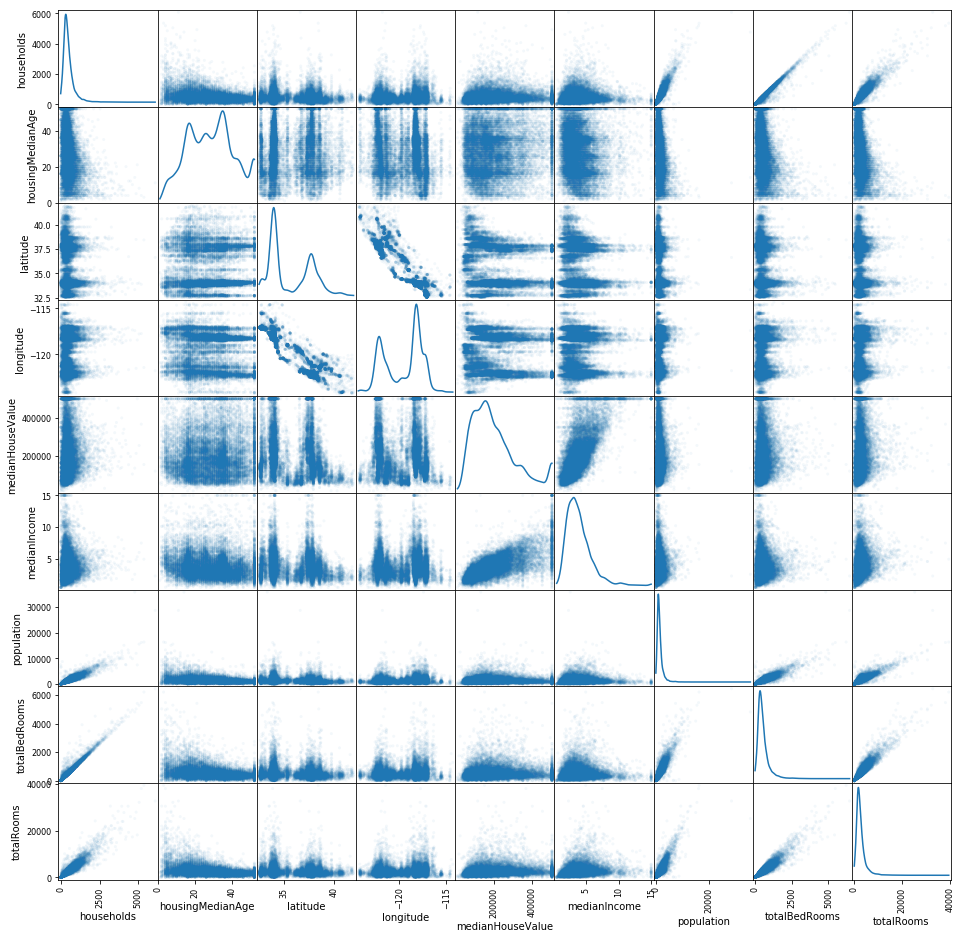

In [75]:
scatter_plt1 = pd.plotting.scatter_matrix(df.toPandas(),
                                 figsize=(16, 16),
                                 diagonal='kde',
                                 alpha=.05)
plt.show()

### Data Preprocessing & Feature Engineering

Let's convert `medianHouseValue` response variable to be in terms of 100,000s.

In [76]:
# Import all from `sql.functions` 
from pyspark.sql.functions import *

# Adjust the values of `medianHouseValue`
df = df.withColumn("medianHouseValue", col("medianHouseValue") / 100000)

# Show the first 2 lines of `df`
df.take(2)

[Row(households=126.0, housingMedianAge=41.0, latitude=37.880001068115234, longitude=-122.2300033569336, medianHouseValue=4.526, medianIncome=8.325200080871582, population=322.0, totalBedRooms=129.0, totalRooms=880.0),
 Row(households=1138.0, housingMedianAge=21.0, latitude=37.86000061035156, longitude=-122.22000122070312, medianHouseValue=3.585, medianIncome=8.301400184631348, population=2401.0, totalBedRooms=1106.0, totalRooms=7099.0)]

 Now, let's do some feature engineering by deriving the following rate variables from the given features.
 
+ roomsPerHousehold
 
+ populationPerHousehold

+ bedroomsPerRoom

The other interactions & transformations that I tried in the model substantially decreased its accuracy.

In [77]:
# Add the new columns to `df`
df1 = df.withColumn("roomsPerHousehold", col("totalRooms")/col("households"))\
    .withColumn("populationPerHousehold", col("population")/col("households"))\
    .withColumn("bedroomsPerRoom", col("totalBedRooms")/col("totalRooms"))

# Inspect the result
df1.first()

Row(households=126.0, housingMedianAge=41.0, latitude=37.880001068115234, longitude=-122.2300033569336, medianHouseValue=4.526, medianIncome=8.325200080871582, population=322.0, totalBedRooms=129.0, totalRooms=880.0, roomsPerHousehold=6.984126984126984, populationPerHousehold=2.5555555555555554, bedroomsPerRoom=0.14659090909090908)

Now let's rearrange the columns and remove the `latitude` and `longitude` variables that we don't expect to have a linear relationship.

In [78]:
# Re-order and select columns
df2 = df1.select("medianHouseValue", 
              "totalBedRooms", 
              "population", 
              "households", 
              "medianIncome", 
              "roomsPerHousehold", 
              "populationPerHousehold", 
              "bedroomsPerRoom")

Let's take another look at the scatter plots. Unfortunately, it does not appear that our new variables have linear relationships with the `medianHouseValue`.

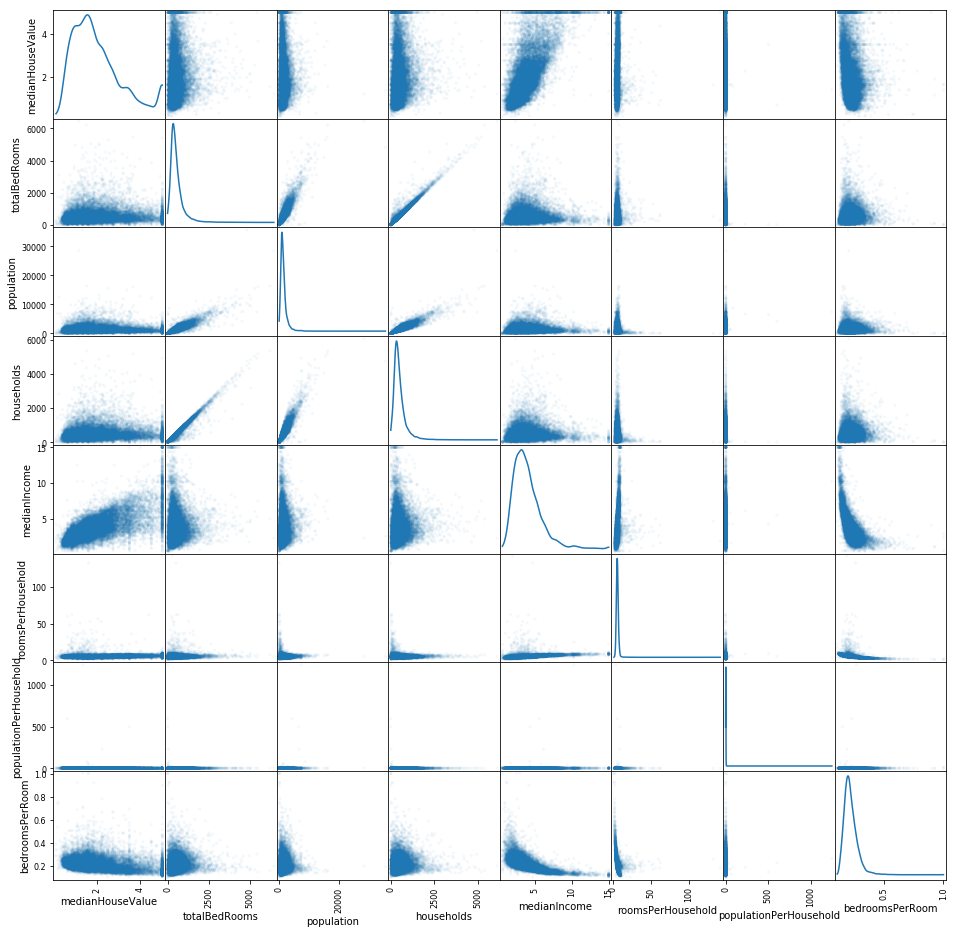

In [79]:
scatter_plt2 = pd.plotting.scatter_matrix(df2.toPandas(),
                                 figsize=(16, 16),
                                 diagonal='kde',
                                 alpha=.05)
plt.show()

### Preprocessing the Data

Let's use `StandardScaler` to cast variables into units of standard deviation.


In [80]:
# Import `DenseVector`
from pyspark.ml.linalg import DenseVector

# Define the `input_data` 
input_data = df2.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

# Replace `df` with the new DataFrame
df2 = spark.createDataFrame(input_data, ["label", "features"])

# Import `StandardScaler` 
from pyspark.ml.feature import StandardScaler

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fit the DataFrame to the scaler
scaler = standardScaler.fit(df2)

# Transform the data in `df2` with the scaler
scaled_df = scaler.transform(df2)

# Inspect the result
scaled_df.take(2)

[Row(label=4.526, features=DenseVector([129.0, 322.0, 126.0, 8.3252, 6.9841, 2.5556, 0.1466]), features_scaled=DenseVector([0.3062, 0.2843, 0.3296, 4.3821, 2.8228, 0.2461, 2.5264])),
 Row(label=3.585, features=DenseVector([1106.0, 2401.0, 1138.0, 8.3014, 6.2381, 2.1098, 0.1558]), features_scaled=DenseVector([2.6255, 2.1202, 2.9765, 4.3696, 2.5213, 0.2031, 2.6851]))]

Next, we will create a training and test data sets.

In [81]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8, .2], seed=1234)

### Building A Machine Learning Model With Spark ML

Now let's create an instance of `LinearRegression` using the regularization and elasticNet parameters, and then fit it to our training data.

In [82]:
# Import `LinearRegression`
from pyspark.ml.regression import LinearRegression

# Initialize `lr`
lr = LinearRegression(labelCol="label", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the data to the model
linearModel = lr.fit(train_data)

Let's make predications and examine the first 5 predictions and actual values. They do not appear to be very good.

In [83]:
# Generate predictions
predicted = linearModel.transform(test_data)

# Extract the predictions and the "known" correct labels
predictions = predicted.select("prediction").rdd.map(lambda x: x[0])
labels = predicted.select("label").rdd.map(lambda x: x[0])

# Zip `predictions` and `labels` into a list
predictionAndLabel = predictions.zip(labels).collect()

# Print out first 5 instances of `predictionAndLabel` 
predictionAndLabel[:5]

[(1.4491508524918457, 0.14999),
 (1.5705029404692372, 0.14999),
 (2.148727956912464, 0.14999),
 (1.5831547768979277, 0.344),
 (1.5182107797955968, 0.398)]

### Evaluating the Model

When we take a look at the model coefficients, we see that only the `medianIncome` variable is of any practical significance. All of the other coefficients were reduced to zero.

In [84]:
# Coefficients for the model
print(linearModel.coefficients)

[0.0,0.0,0.0,0.27623970921500396,0.0,0.0,0.0]


0.9903995774620005

The root mean squared error is high at .87 standard deviations, and r-squared indicates that the model explains only .42 of the variance in the response variable `medianHouseValue`.

In [85]:
# Get the RMSE
print(linearModel.summary.rootMeanSquaredError)

# Get the R2
linearModel.summary.r2

0.8692118678997669


0.4240895287218379

In [ ]:
spark.stop()